# Sanger - DNAseq comparison

This Jupyter notebook reproduces the panels from Figure 5, in which we analyze an additional dataset of B-ALL samples using IM-Fusion and compare the results with results from DNA-sequencing, as presented in the original publication of the dataset.

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

## Datasets

For the comparison, we first load the two datasets. 

### IM-Fusion 

For IM-Fusion, we can directly load the insertions and CTGs from IM-Fusions outputs.

In [2]:
# Read RNA CTGs.
rna_ctgs = (pd.read_csv('../data/processed/sanger/star/ctgs.txt', sep='\t')
              .sort_values(['p_value']))

# Read RNA insertions.
insertions_rna = (pd.read_csv('../data/processed/sanger/star/insertions.txt', sep='\t')
                    .query('support >= 10'))

Note that, in the analysis of this dataset, we filtered insertions with less than 10 supporting reads or mates from the CTG analysis to avoid selecting CTGs with very low support in this relatively deeply sequenced dataset (as these are more likely to represent false positives).

To illustrate this issue, we create two boxplots of the support scores of the most frequently recurring genes, one for the unfiltered dataset and one for the filtered dataset (support >= 10):

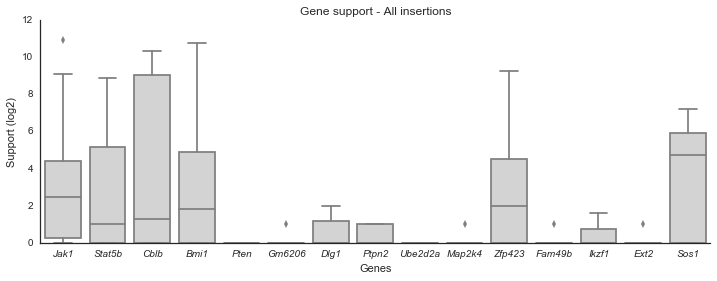

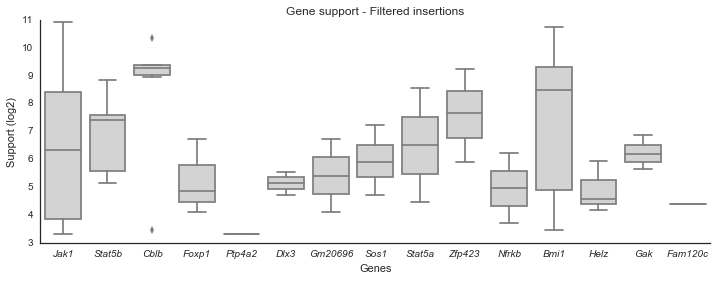

In [3]:
# Rank genes using all insertions.
insertions_rna_all = (
    pd.read_csv('../data/processed/sanger/star/insertions.txt', sep='\t')
      .query('seqname != "1"')
      .assign(support_log=lambda df: np.log2(df['support'])))

ranked_genes_all = (insertions_rna_all
                    .groupby('gene_name')['sample'].nunique()
                    .sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=insertions_rna_all, x='gene_name', y='support_log',
            order=ranked_genes_all.head(n=15).index, color='lightgrey', ax=ax)
sns.despine()
ax.set_xlabel('Genes')
ax.set_ylabel('Support (log2)')
ax.set_title('Gene support - All insertions')
plt.setp(ax.get_xticklabels(), fontstyle='italic')

# Rank genes using insertions with support >= 10.
insertions_rna = insertions_rna_all.query('support >= 10')

ranked_genes = (insertions_rna
                .groupby('gene_name')['sample'].nunique()
                .sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=insertions_rna, x='gene_name', y='support_log',
            order=ranked_genes.head(n=15).index, color='lightgrey', ax=ax)
sns.despine()
ax.set_xlabel('Genes')
ax.set_ylabel('Support (log2)')
ax.set_title('Gene support - Filtered insertions')
plt.setp(ax.get_xticklabels(), fontstyle='italic')

# Draw again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):    
    fig, axes = plt.subplots(figsize=(5.5, 5), nrows=2)
    
    sns.boxplot(data=insertions_rna_all, x='gene_name', y='support_log',
                order=ranked_genes_all.head(n=15).index, color='lightgrey',
                ax=axes[0], linewidth=0.75, fliersize=2)
    plt.setp(axes[0].get_xticklabels(), fontstyle='italic')
    
    sns.boxplot(data=insertions_rna, x='gene_name', y='support_log',
                order=ranked_genes.head(n=15).index, color='lightgrey',
                ax=axes[1], linewidth=0.75, fliersize=2)
    plt.setp(axes[1].get_xticklabels(), fontstyle='italic')
    
    for ax in axes:
        ax.set_xlabel('Genes')
        ax.set_ylabel('Support (log2)')

    axes[0].set_title('All insertions')
    axes[1].set_title('Filtered insertions (support >= 10)')
    
    sns.despine()
    plt.tight_layout()
    
    fig.savefig('../reports/supplemental/figures/fig_s4_ball_support.pdf', bbox_inches='tight')
    plt.close(fig)

This clearly shows that the unfiltered dataset contains many frequently recurring genes with extremely low support scores (e.g. *Pten*, *Gm6206* and *Ube2d2a*). These are nicely removed in the filtered dataset.

### Sanger DNA-seq

For the DNA-seq results, we first load the identified CISs from a file that we obtained through personal communication with the authors of the B-ALL publication:

In [4]:
# Read DNA CTGs.
dna_hits = (pd.read_excel('../data/external/sanger/'
                          'WTSI_DJA_TAPJ_TA_PAX_ONC_B220PLUS_CD19PLUS_CIS_MERGER.xlsx')
              .rename(columns={
                 'Gene': 'gene_name',
                 'Number of Tumours in CIS': 'n_samples'
              })
              .get(['gene_name', 'n_samples'])
              .drop_duplicates())

dna_hits.head()

,gene_name,n_samples
0,CIS7:37319336_15k,14
1,Ophn1,11
2,Jak1,10
3,CIS7:143203112_120k,9
4,Kit,8


Next, we load the insertions from a bed file that was also provided to us. Unforunately, this file does not contain the annotation of these insertions, so we do not know which putative target genes were assigned to each insertions. To circumvent this, we perform our own annotation of the insertions, which simply assigns insertions to the closest gene within 20kb of the insertions location.

In [5]:
from imfusion.model import Insertion
from nbsupport import util, insertions as nb_ins


def _insertions_from_sanger_bed(bed_data):
    """Converts Sanger bed format into an insertion DataFrame."""
    
    name_info = bed_data['name'].str.extract(
        r'_(?P<sample>TAP[\w-]+)\.', expand=True)
    
    col_order = ['id', 'seqname', 'position', 'strand',
                 'support_junction', 'support_spanning',
                 'support', 'sample']
    
    return pd.DataFrame({
        'id': ['INS_{}'.format(i + 1) 
               for i in range(len(bed_data))],
        'seqname': bed_data['chrom'].str.replace('chr', ''),
        'position': bed_data['chromStart'],
        'strand': bed_data['strand'].map({'-': -1, '+': 1}),
        'support_junction': bed_data['score'],
        'support_spanning': 0,
        'support': bed_data['score'],
        'sample': name_info['sample']
    }, columns=col_order)


# Read insertions from Sanger bed file.
bed_path = ('../data/external/sanger/'
            'WTSI_DJA_TAPJ_20130328_TA_PAX_ONC_B220+_CD19+_INSERTIONS_DEFIRESTORMED.bed')

insertions_dna = (util.read_bed(bed_path)
                      .pipe(_insertions_from_sanger_bed))

# Annotate insertions with mm9 genes. Here we assign insertions to genes 
# within 20kb window and then restrict annotation to closest gene.
genes_mm9 = util.fetch_biomart_genes_mm9()

insertion_objs = Insertion.from_frame(insertions_dna)
annotated_objs = nb_ins.annotate_insertions(
    insertion_objs, window=20000, genes=genes_mm9, select_closest=True)

insertions_dna = Insertion.to_frame(annotated_objs)
insertions_dna.head()

,id,seqname,position,strand,support_junction,support_spanning,support,gene_distance,gene_id,gene_name,sample
0,INS_1,7,76004135,-1,9,0,9,NaN,NaN,NaN,TAPJ49-1a
1,INS_2,7,116931954,1,6,0,6,6415.0,ENSMUSG00000034825,Nrip3,TAPJ49-1a
2,INS_3,7,130823505,1,4,0,4,NaN,NaN,NaN,TAPJ49-1a
3,INS_4,14,15533200,-1,3,0,3,2339.0,ENSMUSG00000021733,Slc4a7,TAPJ49-1a
4,INS_5,14,17511791,1,1,0,1,0.0,ENSMUSG00000017491,Rarb,TAPJ49-1a


To check if this produces the expected results, we briefly check the most frequently occurring genes:

In [6]:
# Quick sanity check, to see if the expected hits are among the top genes.
(insertions_dna.groupby(['gene_id', 'gene_name'])
               ['sample'].nunique()
               .sort_values(ascending=False)
               .head(n=10))

gene_id             gene_name
ENSMUSG00000092329  Gm20388      12
ENSMUSG00000056899  Immp2l       11
ENSMUSG00000030849  Fgfr2        11
ENSMUSG00000028530  Jak1         10
ENSMUSG00000021699  Pde4d         9
ENSMUSG00000068205  Macrod2       9
ENSMUSG00000020919  Stat5b        8
ENSMUSG00000030067  Foxp1         8
ENSMUSG00000022708  Zbtb20        8
ENSMUSG00000041654  Slc39a11      7
Name: sample, dtype: int64

This list shows a number of genes from the CIS analysis (*Jak1*, *Stat5b*, *Foxp1*), supporting the validatity of our annotations.

## CTG/CIS comparison

To compare the main hits from both approaches, we compare the rankings of genes between both approaches:

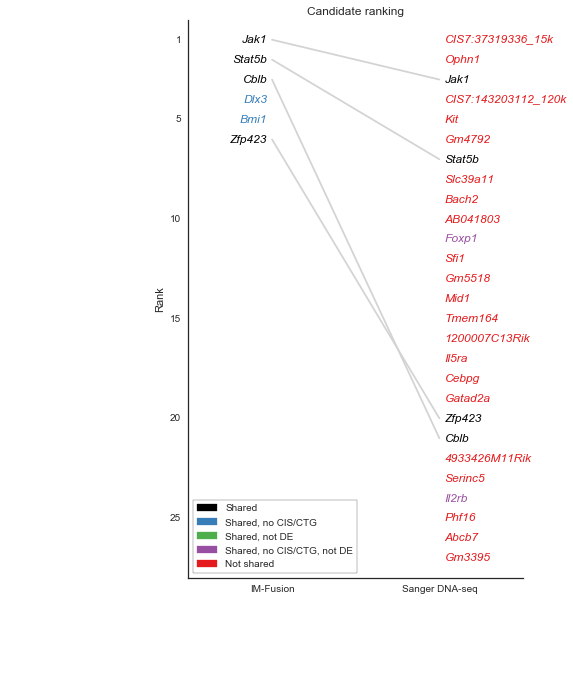

In [7]:
import toolz

from nbsupport import rank
from imfusion.expression import read_exon_counts

# TODO: compare shared with filtered or unfiltered insertions? 
# TODO: DE based on IM-Fusion insertions or on Sanger analysis?

# Read counts and create gene_id --> gene_name map needed for annotate_de.
exon_counts = read_exon_counts('../data/processed/sanger/star/expression.txt')

gene_id_map = toolz.merge(
     dict(zip(insertions_dna['gene_name'], insertions_dna['gene_id'])),
     dict(zip(insertions_rna['gene_name'], insertions_rna['gene_id'])))

# Compare and annotate rankings.
ranks = (
    rank.compare_ranks(rna_ctgs.query('de_pvalue <= 0.05'), dna_hits,
                       suffixes=('_rna', '_dna'))
        .pipe(rank.annotate_ctg, ctgs=rna_ctgs, col_name='ctg_rna')
        .pipe(rank.annotate_ctg, ctgs=dna_hits, col_name='ctg_dna')
        .pipe(rank.annotate_ins, insertions=insertions_rna, col_name='ins_rna')
        .pipe(rank.annotate_ins, insertions=insertions_dna, col_name='ins_dna')
        .pipe(rank.annotate_de, insertions=insertions_rna, 
              exon_counts=exon_counts, gene_id_map=gene_id_map,
              col_name='is_de')
        .pipe(rank.annotate_type))
    
# Plot ranking.
order = rank.RANK_TYPES
palette = (['black'] + sns.color_palette('Set1')[1:4] + 
           [sns.color_palette('Set1')[0]])

fig, ax = plt.subplots(figsize=(6, 10)) 
rank.plot_ranks(ranks, rank_a='rank_rna', rank_b='rank_dna',
                label='gene_name', hue='type', ax=ax,
                palette=palette, order=order,
                legend_kws={'frameon': True, 
                            'loc': 'lower left'},
                label_kws={'fontstyle': 'italic'}) 
ax.set_xticklabels(['IM-Fusion', 'Sanger DNA-seq'])
ax.set_title('Candidate ranking');

# Draw again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2.4, 4.2)) 
    rank.plot_ranks(ranks, rank_a='rank_rna', rank_b='rank_dna',
                    label='gene_name', hue='type', ax=ax,
                    palette=palette, order=order,
                    legend_kws={'frameon': False, 
                                'loc': 'lower left'},
                    label_kws={'fontstyle': 'italic'}) 
    ax.set_xticklabels(['IM-Fusion\n(paired-end)', 'DNA-seq\n(Publication)'])
    ax.set_title('Candidate ranking')
    
    fig.savefig('../reports/figures/fig_5a_ctg_ranks.pdf', bbox_inches='tight')
    plt.close(fig)

This shows that IM-Fusion identifies 4/6 differentially expressed CISs from the DNA-seq analysis. Two genes (*Ilr2b* and *Foxp1*) are identified by IM-Fusion, but are not identified in enough samples to be selected as CTG. Interestingly, IM-Fusion identifies two novel genes that were not selected as CISs in the DNA-seq analysis.

The overlap between the approaches can also be illustrated as a venn diagram:

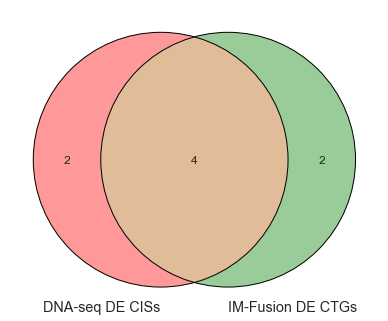

In [8]:
from matplotlib_venn import venn2, venn2_circles

rna_genes = set(rna_ctgs.query('de_pvalue < 0.05')['gene_name'])
dna_genes = {'Jak1', 'Stat5b', 'Cblb', 'Zfp423', 'Foxp1', 'Il2rb'}

fig, ax = plt.subplots()
venn2((rna_genes, dna_genes), 
      set_labels=['DNA-seq DE CISs',
                  'IM-Fusion DE CTGs'],
      ax=ax)
venn2_circles((rna_genes, dna_genes), ax=ax, lw=1);


with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2.4, 2.4))
    venn = venn2(
        (rna_genes, dna_genes), 
        set_labels=['DNA-seq DE CISs',
                    'IM-Fusion DE CTGs'],
        ax=ax)
    venn2_circles((rna_genes, dna_genes), ax=ax, lw=0.5);
    
    for label in venn.set_labels:
        label.set_fontsize(6)
        
    ax.set_title('Candidate overlap')
        
    fig.savefig('../reports/figures/fig_5b_ctg_overlap.pdf', bbox_inches='tight')
    plt.close(fig)

To determine if some insertions/candidates are being missed by IM-Fusion due to lacking depth/clonality, we can compare the support of each insertion with whether it was found in the RNA-seq data by IM-Fusion:

In [9]:
from IPython.display import display

def _summarize_insertions(ins_dna, ins_rna, gene):
    """Summarize the depth of DNA insertions with its RNA status."""
    
    ins_dna = ins_dna.query('gene_name == {!r}'.format(gene))
    ins_rna = ins_rna.query('gene_name == {!r}'.format(gene))
    
    rna_samples = set(ins_rna['sample'].str.replace('_', '-'))
    
    summ = (ins_dna.assign(in_rna=lambda df: df['sample'].isin(rna_samples))
                   .get(['sample', 'seqname', 'position', 'support', 'in_rna'])
                   .sort_values('support', ascending=False)
                   .rename(columns={
                       'seqname': 'chrom',
                       'in_rna': 'rnaseq'
                   }))
    
    return summ
    
    
for gene in ['Jak1', 'Stat5b', 'Foxp1', 'Zfp423', 'Cblb', 'Il2rb']:
    print(gene)
    display(_summarize_insertions(insertions_dna, insertions_rna, gene=gene))

Jak1


,sample,chrom,position,support,rnaseq
259,TAPJ84-3c,4,100864603,669,True
66,TAPJ49-1a,4,100921507,666,True
5926,TAPJ52-2c,4,100892389,336,True
9032,TAPJ52-2a,4,100888660,312,True
698,TAPJ87-6j,4,100920339,92,True
4243,TAPJ72-3c,4,100864603,38,True
7567,TAPJ64-1g,4,100908538,18,True
8385,TAPJ49-5c,4,100886398,4,True
9578,TAPJ7-2e,4,100925452,2,True
6339,TAPJ102-5c,4,100899386,1,False


Stat5b


,sample,chrom,position,support,rnaseq
4080,TAPJ72-3c,11,100689140,122,True
1107,TAPJ68-5a,11,100683416,61,True
7397,TAPJ64-1g,11,100671851,61,True
8031,TAPJ49-5c,11,100687148,48,True
6181,TAPJ102-5c,11,100706741,22,True
2089,TAPJ23-1e,11,100683363,19,False
477,TAPJ87-6j,11,100710357,6,False
6847,TAPJ47-4a,11,100686193,1,True


Foxp1


,sample,chrom,position,support,rnaseq
5767,TAPJ52-2c,6,99217008,227,True
7948,TAPJ49-5c,6,99289945,8,True
6503,TAPJ53-3m,6,99159295,7,False
3321,TAPJ64-3d,6,99190553,3,False
6822,TAPJ47-4a,6,99189463,2,False
4581,TAPJ23-2b,6,99217008,1,False
5214,TAPJ48-5c,6,99217008,1,False
8818,TAPJ52-2a,6,99199292,1,False


Zfp423


,sample,chrom,position,support,rnaseq
8790,TAPJ52-2a,8,90487143,567,False
18,TAPJ49-1a,8,90440457,266,True
4428,TAPJ6-1g,8,90487143,4,False
5707,TAPJ52-2c,8,90335321,2,False
123,TAPJ84-3c,8,90472854,1,True
4020,TAPJ72-3c,8,90487143,1,False


Cblb


,sample,chrom,position,support,rnaseq
6210,TAPJ102-5c,16,52142665,244,True
8122,TAPJ49-5c,16,52141664,123,True
8896,TAPJ52-2a,16,52141414,28,True
4692,TAPJ23-2b,16,52202808,6,False
2155,TAPJ23-1e,16,52017672,1,False
6904,TAPJ47-4a,16,52142665,1,False
9831,TAPJ62-3d,16,52141432,1,False


Il2rb


,sample,chrom,position,support,rnaseq
3607,TAPJ64-3d,15,78325852,24,False
9537,TAPJ7-2e,15,78325852,6,False
645,TAPJ87-6j,15,78324142,1,True
8305,TAPJ49-5c,15,78324099,1,False


This shows that the two missed genes, *Ilr2b* and *Zfp423*, are indeed mainly affected by insertions with relatively low depth. This suggests that these insertions are sub-clonal and are therefore not represented in the RNA-seq sample due to the afore-mentioned issues with sample heterogeneity. Similarly, most of the missed insertions in the other genes also have relatively low support.

In [10]:
# from io import StringIO

# for gene in ['Jak1', 'Stat5b', 'Foxp1', 'Zfp423', 'Cblb', 'Il2rb']:
#     buf = StringIO()
#     _summarize_insertions(insertions_dna, insertions_rna, gene=gene).to_latex(buf, index=False)
    
#     print(gene)
#     print(buf.getvalue())